In [1]:
# Grafica las curvas IDT.

import warnings
import numpy as np
import pandas as pd
import xarray as xr

from scipy import stats

from matplotlib import pyplot as plt
import matplotlib

warnings.filterwarnings( "ignore", category = pd.errors.PerformanceWarning )
warnings.filterwarnings( "ignore", category = UserWarning )

In [2]:
i = 7
j = 8

name = [ "CHIRPS_comp", "CHIRPS_megalopolis", "prec_hist_comp_CHIRPS",
    "prec_hist_comp_estaciones", "prec_era5_hist_hist",
    "prec_mroc_hist_hist", "prec_mroc_2040_2040",
    "WRF_regrid_ERA5_1985_2014_qmap", "WRF_regrid_ERA5_2040_2059_qmap" ]

if i in [0, 1, 2]: t = ["día", "días"]
else: t = ["h", "horas"]

temp_d = "../../../temp/cc_idt/SAM/"
path_par = temp_d + name[i] + "/" + name[i] + "_idf_parametros.nc"
path_val = temp_d + name[i] + "/" + name[i] + "_idf_valores.nc" 
path_ret = temp_d + name[i] + "/" + name[i] + "_tretorno.nc" 

ds_par = xr.open_dataset(path_par)
ds_val = xr.open_dataset(path_val)
ds_ret = xr.open_dataset(path_ret)


path_par_2 = temp_d + name[j] + "/" + name[j] + "_idf_parametros.nc"
path_val_2 = temp_d + name[j] + "/" + name[j] + "_idf_valores.nc" 
path_ret_2 = temp_d + name[j] + "/" + name[j] + "_tretorno.nc" 

ds_par_2 = xr.open_dataset(path_par_2)
ds_val_2 = xr.open_dataset(path_val_2)
ds_ret_2 = xr.open_dataset(path_ret_2)

#ds_par_2["k"].values = ds_par_2["k"].values[:, ::-1]
#ds_par_2["m"].values = ds_par_2["m"].values[:, ::-1]
#ds_par_2["n"].values = ds_par_2["n"].values[:, ::-1]
#ds_par_2["c"].values = ds_par_2["c"].values[:, ::-1]
#ds_par_2["error"].values = ds_par_2["error"].values[:, ::-1]
#ds_val_2["INTENSIDAD"].values = ds_val_2["INTENSIDAD"].values[:, ::-1, :, :]
#ds_ret_2["INTENSIDAD"].values = ds_ret_2["INTENSIDAD"].values[:, ::-1, :, :]
#ds_ret_2["AÑO"].values = ds_ret_2["AÑO"].values[:, ::-1, :, :]
#ds_ret_2["PROBABILIDAD"].values = ds_ret_2["PROBABILIDAD"].values[:, ::-1, :, :]

# W: número de longitud.
# N: número de latitud.
# D: duración.
# T: tiempo de retorno.
# R: Rango de duración.
W = 10
N = 15
D = 4
T = 200
R = (1, 60)

In [3]:
# Utilizar información medida o calculada con distribución.
#RET = True
RET = False
if RET: ret = "valores medidos"
else: ret = "fórmula de Wenzel"

# Utilizar unidades de precipitación o de intensidad.
#PRE = True
PRE = False
pre   = "mm"
p_esp = ""
if PRE:
    p_name = "Precipitación"
    p_D = D
else:
    p_name = "Intensidad"
    pre   += "/" + t[0]
    p_esp += "   "
    p_D    = 1

LON = ds_ret["LONGITUD"].isel( LONGITUD = W ).values
LAT = ds_ret["LATITUD" ].isel( LATITUD  = N ).values

print(f"{LAT:.3f}°N, {LON:.3f}°W")

19.900°N, -99.200°W


In [4]:
# Calcula una intensidad con la fórmula de Wenzel.

# Función que nos genera una curva idT.
def idT(X, k, m, n, d):
    return ( k * X[0] ** m ) / ( X[1] + d ) ** n

param = ds_par.to_dataframe().loc[ ( ds_par.get_index("LONGITUD").unique()[W],
    ds_par.get_index("LATITUD").unique()[N] ) ]
param_2 = ds_par_2.to_dataframe().loc[ (
    ds_par_2.get_index("LONGITUD").unique()[W],
    ds_par_2.get_index("LATITUD").unique()[N] ) ]

print("Intensidad de precipitación obtenida con fórmula de Wenzel, 1985-2014")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.1f} {t[1]}" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( idT( (T, D), *param[:-1] ) ):5.1f} {pre}" )
print( f"Error cuadrático : {param.iloc[4]:.3f}" )
print()

print("Intensidad de precipitación obtenida con fórmula de Wenzel, 2040-2060")
print( f"Ubicación        : {LAT:.3f}°N  {LON:.3f}°W" )
print( f"Duración         : {D:5.1f} {t[1]}" )
print( f"Tiempo de retorno: {T:4d}  años" )
print( f"{p_name}{p_esp}    : {( idT( (T, D), *param_2[:-1] ) ):5.1f} {pre}" )
print( f"Error cuadrático : {param_2.iloc[4]:.3f}" )

Intensidad de precipitación obtenida con fórmula de Wenzel, 1985-2014
Ubicación        : 19.900°N  -99.200°W
Duración         :   4.0 horas
Tiempo de retorno:  200  años
Intensidad       :   5.9 mm/h
Error cuadrático : 13.163

Intensidad de precipitación obtenida con fórmula de Wenzel, 2040-2060
Ubicación        : 19.900°N  -99.200°W
Duración         :   4.0 horas
Tiempo de retorno:  200  años
Intensidad       :  13.0 mm/h
Error cuadrático : 42.394


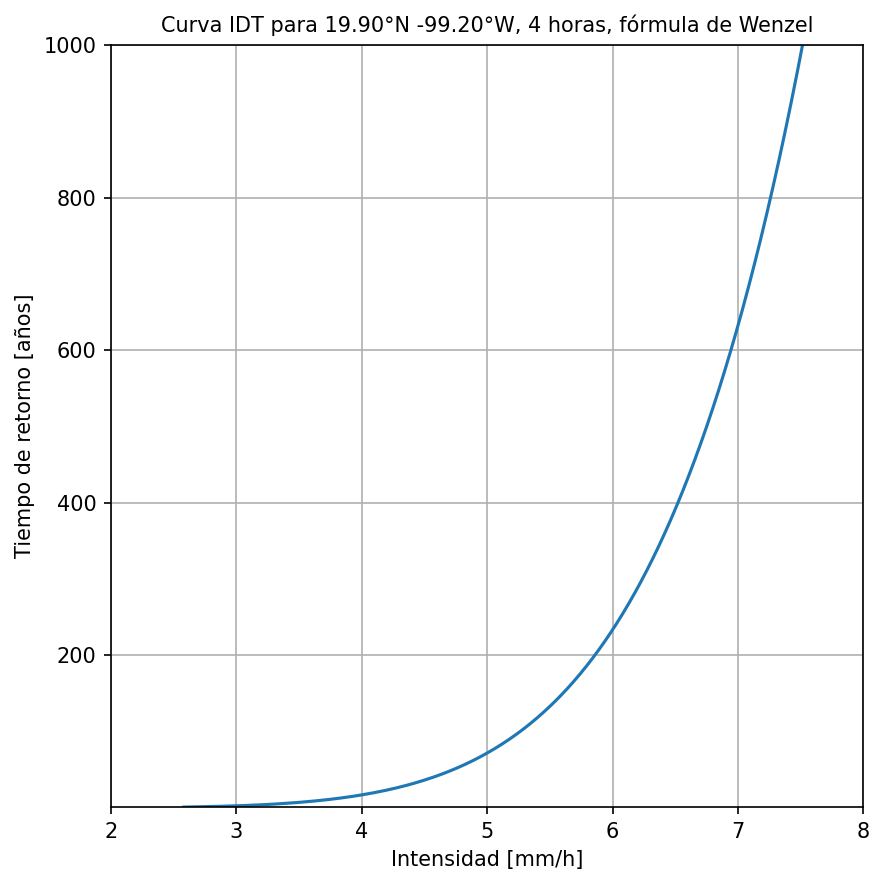

In [5]:
# Graficar una sola duración.

if RET:
    df_i_dur = ds_ret.isel( {"LONGITUD": W, "LATITUD": N}
        ).sel( {"DURACION": D} ).to_dataframe()[ ["INTENSIDAD"] ]
    # Declaramos variables.
    x = df_i_dur["INTENSIDAD"] * p_D
    y = df_i_dur.index
else:
    T_r = np.linspace(1, 1000, 1000)
    D_i = np.full_like(T_r, D) 
    P   = idT( (T_r, D_i), *param[:-1] ) 
    # Declaramos variables.
    x = P * p_D
    y = T_r

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax.plot(x, y)

# Estilo.
ax.grid(which = "both")
#ax.set_yscale("log")
# Nombre de ejes.
ax.set_xlabel(f"{p_name} [{pre}]")
ax.set_ylabel("Tiempo de retorno [años]")
# Límites
if RET:
    ax.set_xlim( np.floor( df_i_dur["INTENSIDAD"].min() / 2 ) * 2,
                 np.ceil(  df_i_dur["INTENSIDAD"].max() / 2 ) * 2 )
    ax.set_ylim( 1, np.ceil( df_i_dur.index.max() / 5 ) * 5 )
else:
    ax.set_xlim( np.floor( x.min() / 2 ) * 2,
                 np.ceil(  x.max() / 2 ) * 2 )
    ax.set_ylim(1, 1000)
# Título.
ax.set_title( f"Curva IDT para {LAT:.2f}°N {LON:.2f}°W, {D} {t[1]}, {ret}",
    size = 10 )

fig.tight_layout()
plt.show()

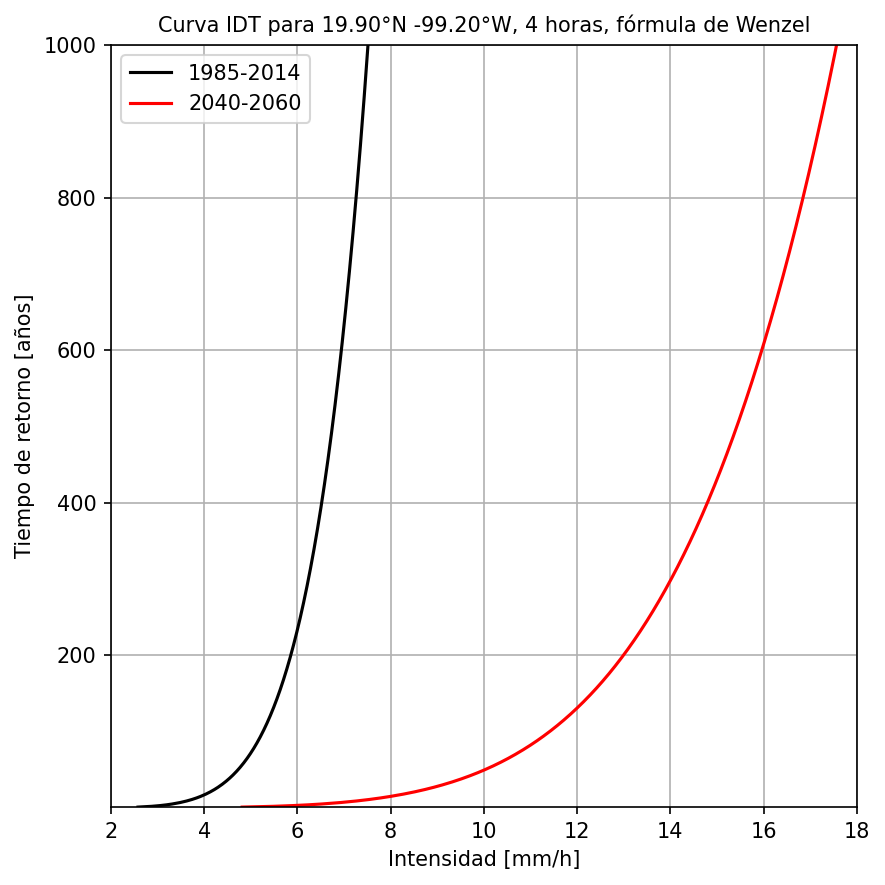

In [6]:
# Graficar una sola duración.

if RET:
    df_i_dur   = ds_ret.isel( {"LONGITUD": W, "LATITUD": N}
        ).sel( {"DURACION": D} ).to_dataframe()[ ["INTENSIDAD"] ]
    df_i_dur_2 = ds_ret_2.isel( {"LONGITUD": W, "LATITUD": N}
        ).sel( {"DURACION": D} ).to_dataframe()[ ["INTENSIDAD"] ]
    # Declaramos variables.
    x   = df_i_dur["INTENSIDAD"] * p_D
    y   = df_i_dur.index
    x_2 = df_i_dur_2["INTENSIDAD"] * p_D
    y_2 = df_i_dur_2.index
else:
    T_r = np.linspace(1, 1000, 1000)
    D_i = np.full_like(T_r, D) 
    P   = idT( (T_r, D_i), *param[:-1] ) 
    P_2 = idT( (T_r, D_i), *param_2[:-1] ) 
    # Declaramos variables.
    x = P * p_D
    x_2 = P_2 * p_D
    y = T_r

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
ax.plot(x, y, color="k")
ax.plot(x_2, y, color="r")

# Estilo.
ax.grid(which = "both")
ax.legend(["1985-2014", "2040-2060"])
#ax.set_yscale("log")
# Nombre de ejes.
ax.set_xlabel(f"{p_name} [{pre}]")
ax.set_ylabel("Tiempo de retorno [años]")
# Límites
if RET:
    ax.set_xlim( np.floor( df_i_dur["INTENSIDAD"].min() / 2 ) * 2,
                 np.ceil(  df_i_dur["INTENSIDAD"].max() / 2 ) * 2 )
    ax.set_ylim( 1, np.ceil( df_i_dur.index.max() / 5 ) * 5 )
else:
    ax.set_xlim( np.floor( min(x.min(), x_2.min()) / 2 ) * 2,
                 np.ceil(  max(x.max(), x_2.max()) / 2 ) * 2 )
    ax.set_ylim(1, 1000)
# Título.
ax.set_title( f"Curva IDT para {LAT:.2f}°N {LON:.2f}°W, {D} {t[1]}, {ret}",
    size = 10 )

fig.tight_layout()
plt.show()

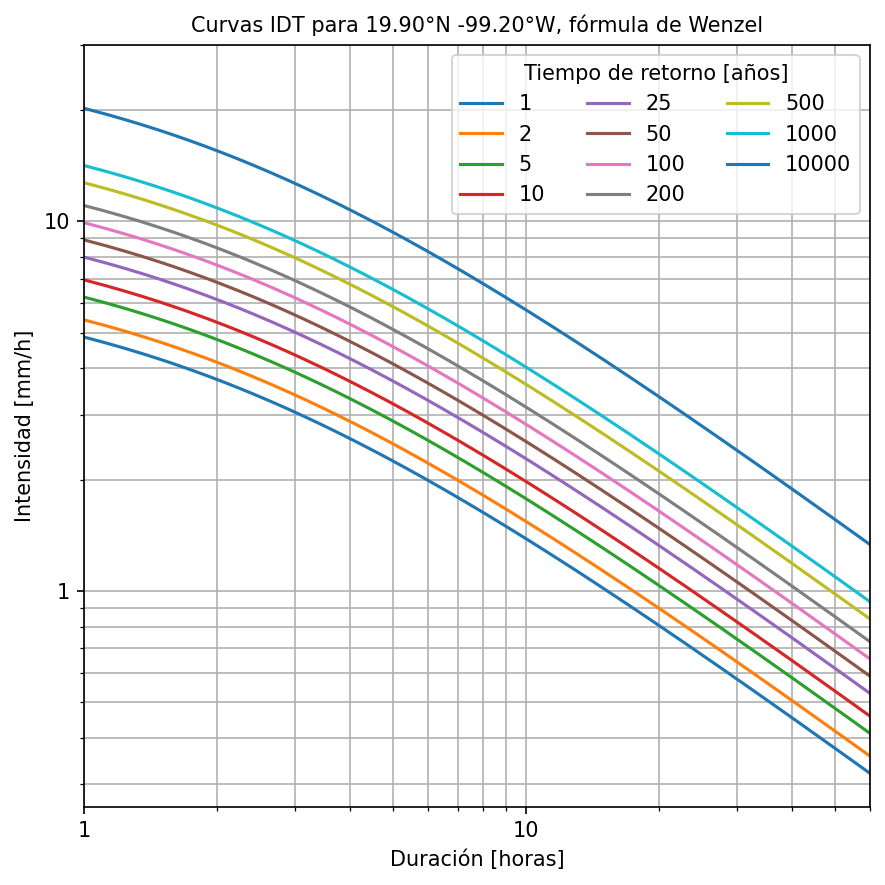

In [7]:
# Graficar todas las duraciones.

if RET: 
    df_i = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
    # Cantidad de tiempos de retorno a saltarse.
    S = 3
    df_i.columns = [f"{x:.1f}" for x in df_i.columns]
else:
    df_i = ds_val.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"].transpose()
    C = df_i.columns.shape[0]
    # Cantidad de tiempos de retorno a saltarse.
    S = 1
    # Calculamos las curvas idT.
    D_i = np.linspace(*R, 1000)
    df_i.columns = list( "A" * C )
    df_i[D_i] = None 
    df_i = df_i.iloc[:, C:]
    for i in df_i.iterrows():
        df_i.loc[ i[0] ] =  idT( (i[0], D_i), *param[:-1] )
    df_i = df_i.transpose()
    df_i.columns = df_i.columns.astype(int)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_i.loc[:, :] = ( df_i.values.transpose()
        * df_i.index.values ).transpose()
ax.plot(df_i.iloc[:, ::S])

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.grid(which = "both")
# Límites
ax.set_xlim(1, df_i.index.max())
ax.set_ylim( np.floor( df_i.values.min() ),
             np.ceil(  df_i.values.max() / 10 ) * 10 )
# Nombre de ejes.
ax.set_xlabel(f"Duración [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend(df_i.columns[::S], title = "Tiempo de retorno [años]", ncol = 3)
# Título.
ax.set_title(f"Curvas IDT para {LAT:.2f}°N {LON:.2f}°W, {ret}", size = 10)

fig.tight_layout()
plt.show()

/tmp/ipykernel_73309/842845296.py:70: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend(["1985-2014", "_", "_", "_", "_",


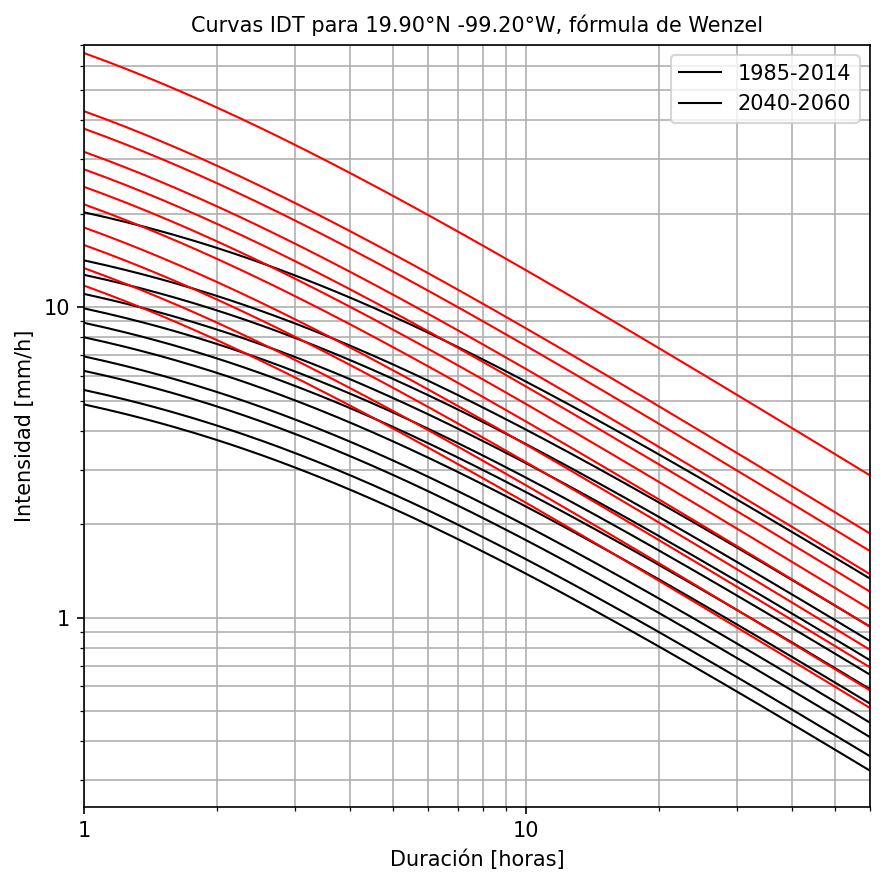

In [8]:
# Graficar todas las duraciones.

if RET: 
    df_i   = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
    df_i_2 = ds_ret_2.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
    # Cantidad de tiempos de retorno a saltarse.
    S = 3
    df_i.columns   = [f"{x:.1f}" for x in df_i.columns]
    df_i_2.columns = [f"{x:.1f}" for x in df_i_2.columns]
else:
    df_i   = ds_val.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"].transpose()
    df_i_2 = ds_val_2.isel( {"LONGITUD": W, "LATITUD": N} 
        ).to_dataframe().unstack( level = 1 )["INTENSIDAD"].transpose()
    C = df_i.columns.shape[0]
    # Cantidad de tiempos de retorno a saltarse.
    S = 1
    # Calculamos las curvas idT.
    D_i = np.linspace(*R, 1000)
    df_i.columns   = list( "A" * C )
    df_i[D_i] = None 
    df_i = df_i.iloc[:, C:]
    for i in df_i.iterrows():
        df_i.loc[ i[0] ] =  idT( (i[0], D_i), *param[:-1] )
    df_i = df_i.transpose()
    df_i.columns = df_i.columns.astype(int)

    df_i_2.columns = list( "A" * C )
    df_i_2[D_i] = None 
    df_i_2 = df_i_2.iloc[:, C:]
    for i in df_i_2.iterrows():
        df_i_2.loc[ i[0] ] =  idT( (i[0], D_i), *param_2[:-1] )
    df_i_2 = df_i_2.transpose()
    df_i_2.columns = df_i_2.columns.astype(int)

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_i.loc[:, :] = ( df_i.values.transpose()
        * df_i.index.values ).transpose()
    df_i_2.loc[:, :] = ( df_i_2.values.transpose()
        * df_i_2.index.values ).transpose()
ax.plot(df_i.iloc[:, ::S], color="k", linewidth=1)
ax.plot(df_i_2.iloc[:, ::S], color="r", linewidth=1)

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.xaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_major_formatter(plt.FormatStrFormatter("%d"))
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.grid(which = "both")
# Límites
ax.set_xlim(1, df_i.index.max())
ax.set_ylim( np.floor( min(df_i.values.min(), df_i_2.values.min()) ),
             np.ceil(  max(df_i.values.max(), df_i_2.values.max())/10 ) * 10 )
# Nombre de ejes.
ax.set_xlabel(f"Duración [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend(["1985-2014", "_", "_", "_", "_",
    "_", "_", "_", "_", "_", "2040-2060"])
# Título.
ax.set_title(f"Curvas IDT para {LAT:.2f}°N {LON:.2f}°W, {ret}", size = 10)

fig.tight_layout()
plt.show()

/tmp/ipykernel_73309/2806887972.py:44: MatplotlibDeprecationWarning: An artist whose label starts with an underscore was passed to legend(); such artists will no longer be ignored in the future.  To suppress this warning, explicitly filter out such artists, e.g. with `[art for art in artists if not art.get_label().startswith('_')]`.
  ax.legend( ["Medido"] + ["_"] * ( df_ret.iloc[:, ::S].shape[1] - 1 )


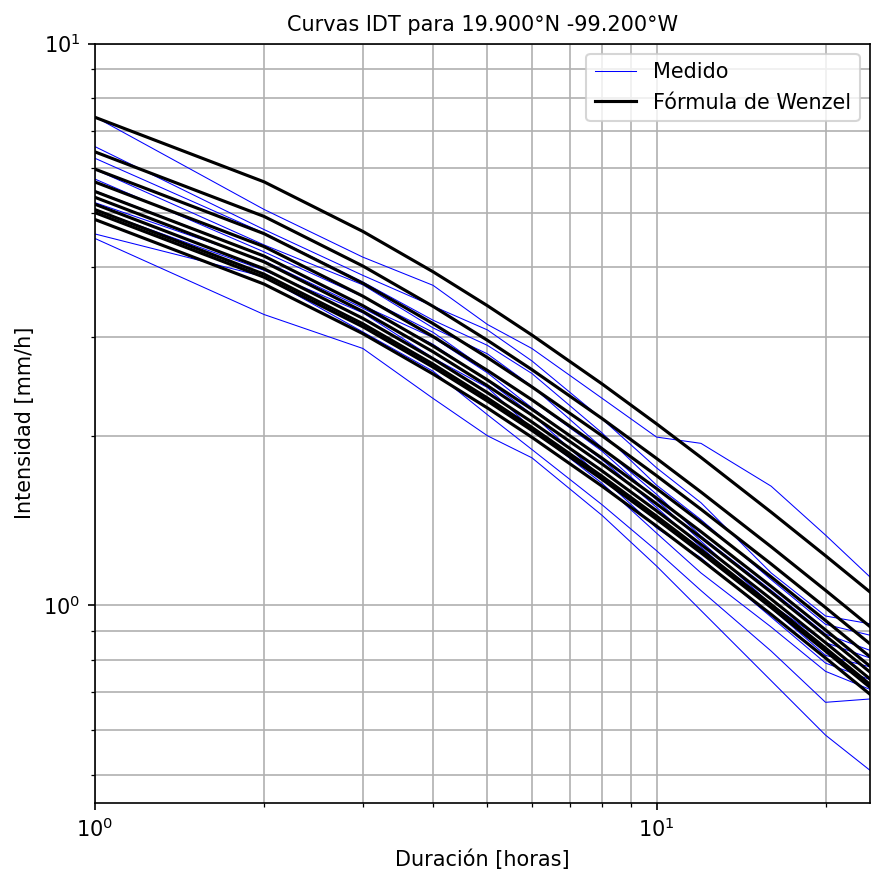

In [9]:
# Graficar las mediciones vs. Wenzel.


df_ret = ds_ret.isel( {"LONGITUD": W, "LATITUD": N} 
    ).to_dataframe().unstack( level = 1 )["INTENSIDAD"]
# Cantidad de tiempos de retorno a saltarse.
S = 3
df_ret.columns = [f"{x:.1f}" for x in df_ret.columns]

df_val = df_ret.copy()
for i in df_val.iterrows():
    df_val.loc[ i[0] ] =  idT( ( df_val.columns.astype(float),
        i[0]), *param[:-1] )

# Incializamos gráfica.
fig, ax = plt.subplots()
fig.set_facecolor("w")
fig.set_size_inches(6, 6)
fig.set_dpi(150) 

# Graficamos.
if PRE:
    df_ret.loc[:, :] = ( df_ret.values.transpose()
        * df_ret.index.values ).transpose()
ax.plot(df_ret.iloc[:, ::S], color = "b", linewidth = 0.5)
ax.plot(df_val.iloc[:, ::S], color = "k", linewidth = 1.5)

# Estilo.
# Escala logarítmica.
ax.set_xscale("log")
ax.set_yscale("log")
ax.grid(which = "both")
ax.xaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
ax.yaxis.set_minor_formatter(matplotlib.ticker.NullFormatter())
# Límites
ax.set_xlim(1, df_ret.index.max())
ax.set_ylim( np.floor( df_ret.values.min() ),
             np.ceil(  df_ret.values.max() / 10 ) * 10 )

# Nombre de ejes.
ax.set_xlabel(f"Duración [{t[1]}]")
ax.set_ylabel(f"{p_name} [{pre}]")
# Leyendas.
ax.legend( ["Medido"] + ["_"] * ( df_ret.iloc[:, ::S].shape[1] - 1 )
    + ["Fórmula de Wenzel"] )
# Título.
ax.set_title(f"Curvas IDT para {LAT:.3f}°N {LON:.3f}°W", size = 10)

fig.tight_layout()
plt.show()